In [1]:
from deep_traffic_generation.tcvae import TCVAE
from deep_traffic_generation.VAE_Generation import SingleStageVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from os import walk

In [2]:
from scipy.spatial.distance import cdist
from tqdm.autonotebook import tqdm
import numpy as np

def energy_distance(x, y):

    """Compute energy distance between the distributions of 2 samples of different length
    """
    n1 = x.shape[0]
    n2 = y.shape[0]
    a = cdist(x, y, "euclidean").mean()
    b = cdist(x, x, "euclidean").mean()
    c = cdist(y, y, "euclidean").mean()
    # e = (n1 * n2 / (n1 + n2)) * (2 * a - b - c)
    e = (2 * a - b - c)

    return e

In [3]:
dataset = TrafficDataset.from_file(
    # "../../deep_traffic_generation/data/traffic_noga_tilFAF_train_enriched.pkl",
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

dataset_fc = TrafficDataset.from_file(
    # "../../deep_traffic_generation/data/traffic_noga_tilFAF_train_enriched.pkl",
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="linear",
    info_params={"features": ["latitude", "longitude"], "index": -1},)


In [4]:
dataset_m = TrafficDataset.from_file(
    # "../../deep_traffic_generation/data/traffic_noga_tilFAF_train_enriched.pkl",
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=None,
    shape="linear",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

# GMM

In [9]:
import random
from sklearn.mixture import GaussianMixture
e_distances_gm = []

gm = GaussianMixture(n_components=24).fit(dataset_m.data.numpy())

for i in tqdm(range(100)):
    ids = random.sample(range(len(dataset_fc)), 3000)
    true = dataset_fc.data[ids].numpy()
    generated = dataset_fc.scaler.transform(gm.sample(3000)[0])
    e_distances_gm.append(energy_distance(true, generated))

print(np.mean(e_distances_gm)) 

#24 composantes
#21174

#norm
#0.0590

#increases when number of sample increases

  0%|          | 0/100 [00:00<?, ?it/s]

/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/mixture/_base.py:426: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/mixture/_base.py:426: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/mixture/_base.py:426: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/mixture/_base.py:426: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/cluster/home/kruu/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/mixture/_base.py:426: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multiv

0.05782763758561517


In [5]:
import matplotlib.pyplot as plt
from traffic.core import Traffic

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

traffic = Traffic.from_file("../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl") 

g1 = Generation(
    generation=GaussianMixture(n_components=24),
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1, 1))
).fit(traffic)

In [7]:
from traffic.core.projection import EuroPP

traf_gm = g1.sample(5000, projection=EuroPP(), coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)
traf_gm.to_pickle("GMM_generation_5000.pkl")

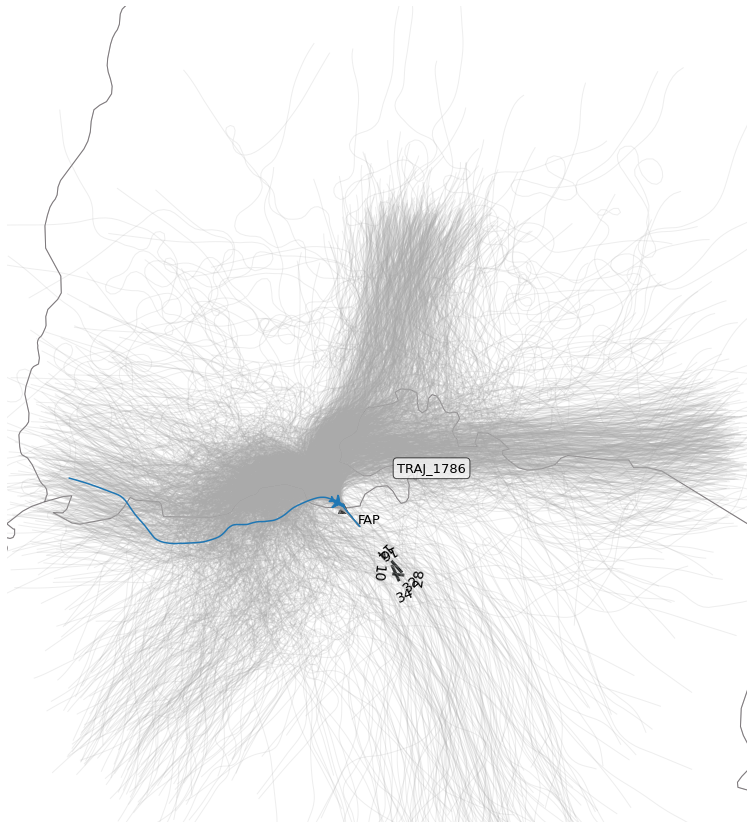

In [8]:
import matplotlib.pyplot as plt
from traffic.core.projection import EuroPP
from traffic.drawing import countries
from traffic.data import navaids
from traffic.data import airports

traf_gm = g1.sample(2000, projection=EuroPP(), coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((7.5, 9.5, 47, 48.5))

    traf_gm.plot(ax, alpha=0.2)

    k =  np.random.randint(len(traf_gm))
    # k = 9720
    traf_gm[k].plot(ax, color="#1f77b4", lw=1.5)
    traf_gm[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

# TCVAE + Vamprior

In [10]:
path = "../../deep_traffic_generation/lightning_logs/tcvae/version_1/"
t_m = SingleStageVAE(X = dataset, sim_type = "generation")
t_m.load(path, dataset.parameters)
g_m = Generation(generation=t_m, features = t_m.VAE.hparams.features, scaler=dataset.scaler) 

In [11]:
import random

e_distances_vae = []
n_samples = 3000
features = ["track", "groundspeed", "altitude", "timedelta"]
_ = t_m.latent_space(1) # just to execture the forward of lsr to calculate prior means
p_z = t_m.VAE.lsr.get_prior()

for i in tqdm(range(100)):
    ids = random.sample(range(len(dataset_fc)), 3000)
    true = dataset_fc.data[ids].numpy()
    z_m = p_z.sample(torch.Size([n_samples])).squeeze(1)
    generated = t_m.decode(z_m)
    generated = dataset_fc.scaler.transform(generated)
    e_distances_vae.append(energy_distance(true, generated))

print(np.mean(e_distances_vae))

# with kld 1: 37716
# normalized: 0.0103

  0%|          | 0/100 [00:00<?, ?it/s]

0.010004490185998041


# TCVAE + gaussian prior

In [8]:
path = "../../deep_traffic_generation/lightning_logs/tcvae/version_0/"
t_m = SingleStageVAE(X = dataset, sim_type = "generation")
t_m.load(path, dataset.parameters)
g_m = Generation(generation=t_m, features = t_m.VAE.hparams.features, scaler=dataset.scaler) 

In [9]:
from traffic.core.projection import EuroPP

traf_gaussian_tcvae = g_m.sample(5000, projection=EuroPP(), coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)
traf_gaussian_tcvae.to_pickle("Gaussian_tcvae_generation_5000.pkl")

In [11]:
import random

e_distances_vae = []
n_samples = 3000
features = ["track", "groundspeed", "altitude", "timedelta"]
z = t_m.latent_space(1) # just to execture the forward of lsr to calculate prior means
p_z = t_m.VAE.lsr.get_prior()

for i in tqdm(range(100)):
    ids = random.sample(range(len(dataset_fc)), 3000)
    true = dataset_fc.data[ids].numpy()
    z_m = p_z.sample(torch.Size([n_samples])).squeeze(1)
    generated = t_m.decode(z_m)
    generated = dataset_fc.scaler.transform(generated)
    e_distances_vae.append(energy_distance(true, generated))

print(np.mean(e_distances_vae))

#generated
# 10819224

#reconstructed
#1058

#normalized
#2.4052

  0%|          | 0/100 [00:00<?, ?it/s]

2.405213506409683


# FCVAE

In [5]:
path = "../../deep_traffic_generation/lightning_logs/fcvae/version_0/"
t_m = SingleStageVAE(X = dataset_fc, sim_type = "generation")
t_m.load(path, dataset_fc.parameters)
g_m = Generation(generation=t_m, features = t_m.VAE.hparams.features, scaler=dataset.scaler) 

In [6]:
from traffic.core.projection import EuroPP

traf_fcvae = g_m.sample(5000, projection=EuroPP(), coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)
traf_fcvae.to_pickle("FCVAE_generation_5000.pkl")

In [12]:
import random

e_distances_vae = []
n_samples = 3000
features = ["track", "groundspeed", "altitude", "timedelta"]
z = t_m.latent_space(1) # just to execute the forward of lsr to calculate prior means
p_z = t_m.VAE.lsr.get_prior()

for i in tqdm(range(100)):
    ids = random.sample(range(len(dataset_fc)), 3000)
    true = dataset_fc.data[ids].numpy()
    z_m = p_z.sample(torch.Size([n_samples])).squeeze(1)
    generated = t_m.decode(z_m)
    generated = dataset_fc.scaler.transform(generated)
    e_distances_vae.append(energy_distance(true, generated))

print(np.mean(e_distances_vae))

#Generated
#2100195

#Reconstructed
#57727

#normalized
#0.9265


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 